# Baseline with Text Classification

Now that we have our baseline model and our text classification model, we have to figure out a method to combine the two.

In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm

In [2]:
# retrieve the data
merged = pd.read_csv('../../DataPlus/all_data_merged.csv')

## Baseline Model

Model only based on age and Gleason score

In [3]:
# predictive model module
import GeneralModel as gm

In [4]:
# prepares dataframe for the baseline model (prepare_df defaults to baseline)
bm_df = gm.prepare_df(merged)

# of Data Points: 392


In [5]:
bm_fscore, _ = gm.general_model(bm_df)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Average Metrics:

Positive Class Precision: 0.636

Positive Class Recall: 0.766

Negative Class Precision: 0.849

Negative Class Recall: 0.736



In [6]:
# F-score for baseline model
bm_fscore

0.6951637004461538

## Text Classification

Model based only on text classification

In [7]:
import Preprocessing as pre
import KFoldTextClassification as ktc
import CompilingCorpus as cc

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
PROCESS_PIPELINE = [
    pre.remove_non_alpha,
    pre.remove_parentheses,
    pre.make_lowercase,
    pre.remove_stopwords,
    pre.lemmatize
]

In [9]:
# takes dataframe and processes it for text classification
def create_text_df(df):
    dropped_df = df.dropna(subset=['Convo_1', 'txgot_binary'])
    
    # preprocesses transcripts
    col_processed = [pre.text_preprocessing(text, PROCESS_PIPELINE) for text in tqdm(dropped_df['Convo_1'])]
    dropped_df['Convo_1'] = cc.untokenize(col_processed)
    
    return dropped_df

In [10]:
text_df = create_text_df(merged)

HBox(children=(IntProgress(value=0, max=356), HTML(value='')))

In [11]:
decision_values, _ = ktc.strat_kfold_text(text_df, folds=10, iterations=5)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[23  0 11  3]
[22  1  6  7]
[22  1  5  8]
[14  9  2 11]
[19  4  7  6]
[21  1  9  4]
[18  4  6  7]
[22  0  6  7]
[22  0  6  7]
[22  0  5  8]
[19  4  0 14]
[22  1  7  6]
[20  3  6  7]
[23  0 12  1]
[15  8  4  9]
[17  5  2 11]
[22  0  7  6]
[16  6  3 10]
[17  5  5  8]
[22  0  8  5]
[21  2  9  5]
[23  0  7  6]
[17  6  2 11]
[21  2  3 10]
[21  2  3 10]
[14  8  2 11]
[21  1  7  6]
[22  0  9  4]
[15  7  1 12]
[19  3  1 12]
[17  6  3 11]
[23  0 11  2]
[22  1  9  4]
[16  7  2 11]
[21  2  3 10]
[19  3  3 10]
[19  3  6  7]
[21  1  4  9]
[22  0 11  2]
[19  3  2 11]
[23  0  7  7]
[20  3  5  8]
[23  0  7  6]
[21  2  2 11]
[23  0 11  2]
[18  4  9  4]
[22  0  3 10]
[20  2  7  6]
[20  2  7  6]
[20  2  7  6]

AVG METRICS:

Surveillance Class Precision: 0.808

Surveillance Class Recall: 0.573

Treatment Class Precision: 0.795

Treatment Class Recall: 0.89



### Visualizing Text Classification Results

The decision values that were outputted represents the results of the model's decision function. When predicting, we defined a threshold to turn decision values into discrete predictions. But maybe we can use these decision values as a feature, adding them to the baseline model.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
text_df['decision_values'] = decision_values

In [21]:
import pickle

In [22]:
# save dataframe with decision values for later use
pickle.dump(text_df, open('dec_dataframe.p', 'wb'))

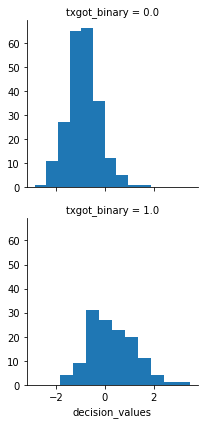

In [16]:
g = sns.FacetGrid(text_df,  row="txgot_binary")
g = g.map(plt.hist, "decision_values")

So it looks like there is a distinct difference in the distributions of the decision values for those who chose active surveillance and those who did not. I'm guessing that the default threshold for text classification is 0, but looking at the distributions, a lower threshold could produce even better results.

## Combining Text Classification and Baseline Model

To combine text classification and the baseline model, we will use the decision values from text classification as a new feature to add to the baseline model.

In [17]:
# we will use text_df as the base dataframe
raw_df = text_df.copy()

In [18]:
combined_df = gm.prepare_df(raw_df, cont_vars=['age', 'decision_values'])

# of Data Points: 356


In [19]:
combined_fscore = gm.general_model(combined_df)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Average Metrics:

Positive Class Precision: 0.77

Positive Class Recall: 0.687

Negative Class Precision: 0.83

Negative Class Recall: 0.868



In [20]:
# F-score for combined model
combined_fscore

(0.7263774327358247,
 {'negative precision': 0.8299613105029081,
  'negative recall': 0.8681159420289853,
  'positive precision': 0.770087714573009,
  'positive recall': 0.6873626373626376})